In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


Using TensorFlow backend.


# Data preparation

In [2]:
# Load the data
train = pd.read_csv("digit-recognizer/train.csv")
test = pd.read_csv("digit-recognizer/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

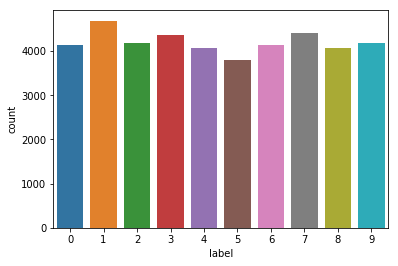

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

## Normalization

In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label encoding

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## Split training and valdiation set

In [9]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

In [10]:
print("Training images: {}".format(X_train.shape))
print("Training labels: {}".format(Y_train.shape))
print("Validation images: {}".format(X_val.shape))
print("Validation labels: {}".format(Y_val.shape))

Training images: (33600, 28, 28, 1)
Training labels: (33600, 10)
Validation images: (8400, 28, 28, 1)
Validation labels: (8400, 10)


## Examples

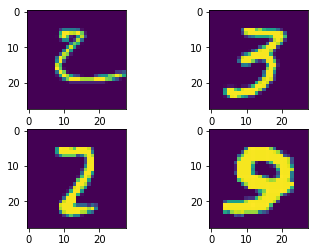

In [11]:
# Some examples
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_train[0][:,:,0])
axarr[0,1].imshow(X_train[1][:,:,0])
axarr[1,0].imshow(X_train[2][:,:,0])
axarr[1,1].imshow(X_train[3][:,:,0])

In [12]:
print(Y_train[0])
print(Y_train[1])
print(Y_train[2])
print(Y_train[3])

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


# CNN

In [13]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

## Optimizer

In [15]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

## Compile

In [16]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## Callbacks

In [17]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

os.makedirs("weights", exist_ok=True)
checkPoint = ModelCheckpoint("weights/digit.weights.{epoch:02d}-{val_acc:.2f}.hdf5",
                             monitor='val_acc',
                             save_weights_only=True)

In [18]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 32

In [19]:
datagen = ImageDataGenerator()

In [20]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_steps = X_val.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction, checkPoint])

Epoch 1/10
1050/1050 [==============================] - 94s 89ms/step - loss: 0.2167 - acc: 0.9323 - val_loss: 0.0586 - val_acc: 0.9811
Epoch 2/10
1050/1050 [==============================] - 93s 88ms/step - loss: 0.0844 - acc: 0.9758 - val_loss: 0.0442 - val_acc: 0.9852
Epoch 3/10
1050/1050 [==============================] - 86s 82ms/step - loss: 0.0735 - acc: 0.9793 - val_loss: 0.0512 - val_acc: 0.9850
Epoch 4/10
1050/1050 [==============================] - 91s 86ms/step - loss: 0.0771 - acc: 0.9790 - val_loss: 0.0488 - val_acc: 0.9858
Epoch 5/10
1050/1050 [==============================] - 90s 86ms/step - loss: 0.0803 - acc: 0.9797 - val_loss: 0.0617 - val_acc: 0.9836
Epoch 6/10
1050/1050 [==============================] - 92s 88ms/step - loss: 0.0879 - acc: 0.9783 - val_loss: 0.0455 - val_acc: 0.9857
Epoch 7/10
1050/1050 [==============================] - 92s 88ms/step - loss: 0.0895 - acc: 0.9791 - val_loss: 0.0606 - val_acc: 0.9836

Epoch 00007: ReduceLROnPlateau reducing learnin

# Metrics

## Training and Validation plots

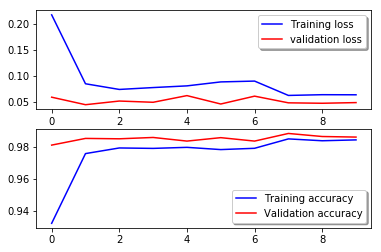

In [21]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Confusion Matrix 

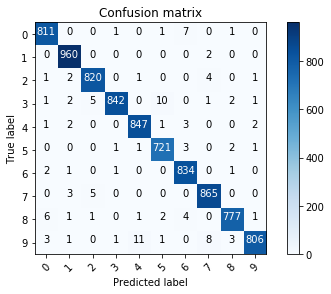

In [22]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Accuracy, recalll, presition and F1

In [23]:
print("Accuracy: {}".format(accuracy_score(Y_true, Y_pred_classes)))
print("Recall: {}".format(recall_score(Y_true, Y_pred_classes, average=None))) # TP / (TP + FN)
print("Precision: {}".format(precision_score(Y_true, Y_pred_classes, average=None))) # TP / (TP + FP)
print("F1: {}".format(f1_score(Y_true, Y_pred_classes, average=None)))
# https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

Accuracy: 0.9860714285714286
Recall: [ 0.98781973  0.997921    0.98914355  0.97453704  0.98948598  0.98902606
  0.99404052  0.9908362   0.97982346  0.96642686]
Precision: [ 0.9830303   0.98765432  0.98676294  0.99527187  0.98373984  0.97961957
  0.9800235   0.98295455  0.98854962  0.99261084]
F1: [ 0.9854192   0.99276112  0.98795181  0.98479532  0.98660454  0.98430034
  0.98698225  0.98687963  0.98416719  0.97934386]


## Missclasification cases

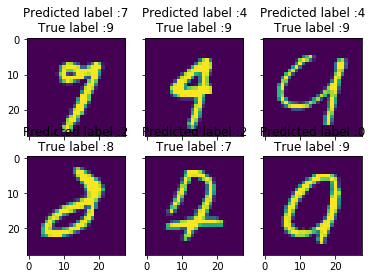

In [24]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

# Predictions

In [25]:
# predict results
results = model.predict(test)
print("Prediction shape: {}".format(results.shape))
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
print("Prediction shape after argmax: {}".format(results.shape))
results = pd.Series(results,name="Label")

Prediction shape: (28000, 10)
Prediction shape after argmax: (28000,)


## Submission

In [26]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("digit-recognizer/submission1.csv",index=False)
# https://www.kaggle.com/c/digit-recognizer